<a href="https://colab.research.google.com/github/liamcarroll/sleep-stage-classifier-sklearn/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---

The dataset used in this notebook was collected by researchers at the University of Michigan [1]. The dataset contains raw physiological signals for 31 subjects, recorded using an Apple Watch device over a 7- to 14-day ambulatory recording period. These signals include x, y, z acceleration (in units of g) and heart rate (in bpm, measured from photoplethysmography), as well as labeled sleep scored from gold-standard polysomnography (PSG) during an eight hour sleep opportunity on the final night of the recording period.

In the paper associated with the aformentioned study, the authors investigated the performance of four different algorithms at both sleep/wake and wake\/NREM\/REM classification. The best-performing algorithm for boths tasks was a Neural Network classifier, scoring 90% of epochs (or windows) correctly for binary sleep/wake classification and 72% accuracy when differentiating wake, NREM and NREM sleep. The authors suggested that classification models capable of distinguishing the more granular sleep stage labels available from PSG would be a good direction for future work.

In this notebook, we experiment with various different classification models with the goal of being able to predict which of the five different stages of sleep a subject is in given their physiological signals, i.e. 0 $\Leftrightarrow$ wake; 1-4 $\Leftrightarrow$ progressively deeper stages of NREM sleep and 5 $\Leftrightarrow$ REM sleep. The notebook structure is as follows:

**1.**   Data Preparation  
**2.**   Feature Engineering  
**3.**   Regression  
**4.**   Classification  
**5.**   Validation of the Models  
**6.**   Conclusion  







# Installing and Importing Relevant Packages

In [ ]:
%%capture
!apt-get install swig -y
!pip install Cython tsfel

In [ ]:
import os
import warnings
import time

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import tsfel

from google.colab import drive
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, r2_score, confusion_matrix

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from google.colab import drive
import json

# 1. Data Preparation
---

We use Google Drive to host our data, so we need to connect our shared drive in order to access it.

In [ ]:
drive.mount('/content/drive')

#Changing to the sleep_classifiers directory
# os.chdir("/content/drive/My Drive/Assignment_2") # Adam
os.chdir('/content/drive/My Drive/College - 4th Year/CA4015_AdvancedML/Assignment_2') # Liam

Mounted at /content/drive


## Explore the Data

The first step in terms of data exploration is simply to load in the different datasets which are available to us and examine the structure and nature of the data. The below function loads in the data for a chosen subject and returns four DataFrame's containing the heart, motion, steps and labelled sleep data for that subject.


In [ ]:
def load_data(data_folder, subject):
  heart_df = pd.read_csv(os.path.join(data_folder, "heart_rate", f"{subject}_heartrate.txt"), header=None)
  heart_df.columns = ["timestamp", "heart_rate"]
  heart_df.sort_values("timestamp", inplace=True, ignore_index=True)
  heart_df.drop_duplicates("timestamp", inplace=True)

  motion_df = pd.read_csv(os.path.join(data_folder, "motion", f"{subject}_acceleration.txt"), sep=" ", header=None)
  motion_df.columns = ["timestamp", "x", "y", "z"]
  motion_df.sort_values("timestamp", inplace=True, ignore_index=True)
  motion_df.drop_duplicates("timestamp", inplace=True)

  steps_df = pd.read_csv(os.path.join(data_folder, "steps", f"{subject}_steps.txt"), header=None)
  steps_df.columns = ["timestamp", "steps"]
  steps_df.sort_values("timestamp", inplace=True, ignore_index=True)
  steps_df.drop_duplicates("timestamp", inplace=True)

  labels_df = pd.read_csv(os.path.join(data_folder, "labels", f"{subject}_labeled_sleep.txt"), sep=" ", header=None)
  labels_df.columns = ["timestamp", "label"]
  labels_df.sort_values("timestamp", inplace=True, ignore_index=True)
  labels_df.drop_duplicates("timestamp", inplace=True)

  return heart_df, motion_df, steps_df, labels_df

Next, we load in the data for a random subject and plot the data for the different physiological signals and labelled sleep over time.

In [ ]:
subject = 1066528
heart_df, motion_df, steps_df, labels_df = load_data("dev/data/sleep_data", subject)

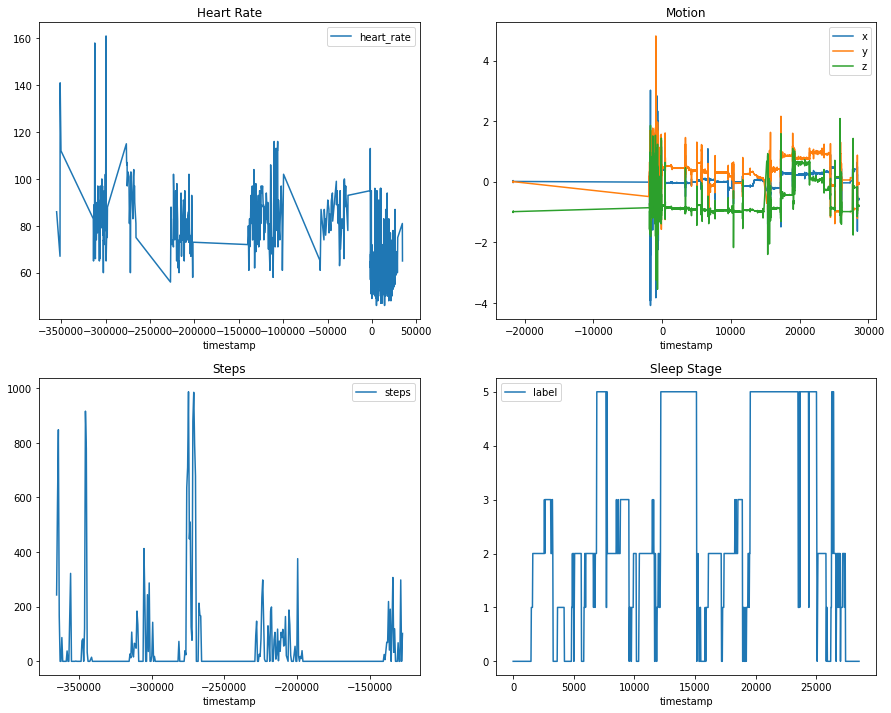

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

heart_df.plot(x="timestamp", ax=ax[0, 0], title="Heart Rate")
motion_df.plot(x="timestamp", ax=ax[0, 1], title="Motion")
steps_df.plot(x="timestamp", ax=ax[1, 0], title="Steps")
labels_df.plot(x="timestamp", ax=ax[1, 1], title="Sleep Stage")

From the plots above, it's clear that some data exists prior to the commencement of the *polysomnography* (PSG) study, which begins at timestamp 0. This extra data is explained by Walch et. al [1] in the related paper. Apple Watch devices were worn continuosly by subjects during the 7- to 14-day ambulatory recording period preceding PSG. This ambulatory recording period allowed the authors to estimate each subject's daily activity patterns, which were used to generate predictions of circadian phase, later used as a "*clock proxy*" feature in their study. Replicating this "clock proxy" feature may be very useful for classification so we will endeavour to experiment with a similar feature in our own classification implementation.

Other than for this "clock proxy" feature, the data preceding the PSG study will not be of much use for classification so the next step is to crop the heart, motion and steps data to the labelled range.

## Cropping to the Labelled Range

The function below crops the raw heart, motion and steps data to the same range as the sleep labels.

In [ ]:
def filter_df(heart_df, motion_df, steps_df, labels_df):
  # Filter to within labelled data range
  time_min, time_max = labels_df["timestamp"].min(), labels_df["timestamp"].max()

  return (
      heart_df[(time_min <= heart_df["timestamp"]) & (heart_df["timestamp"] <= time_max)],
      motion_df[(time_min <= motion_df["timestamp"]) & (motion_df["timestamp"] <= time_max)],
      steps_df[(time_min <= steps_df["timestamp"]) & (steps_df["timestamp"] <= time_max)]
      )

In [ ]:
heart_df2, motion_df2, steps_df2 = filter_df(heart_df, motion_df, steps_df, labels_df)

Visualising the cropped data...

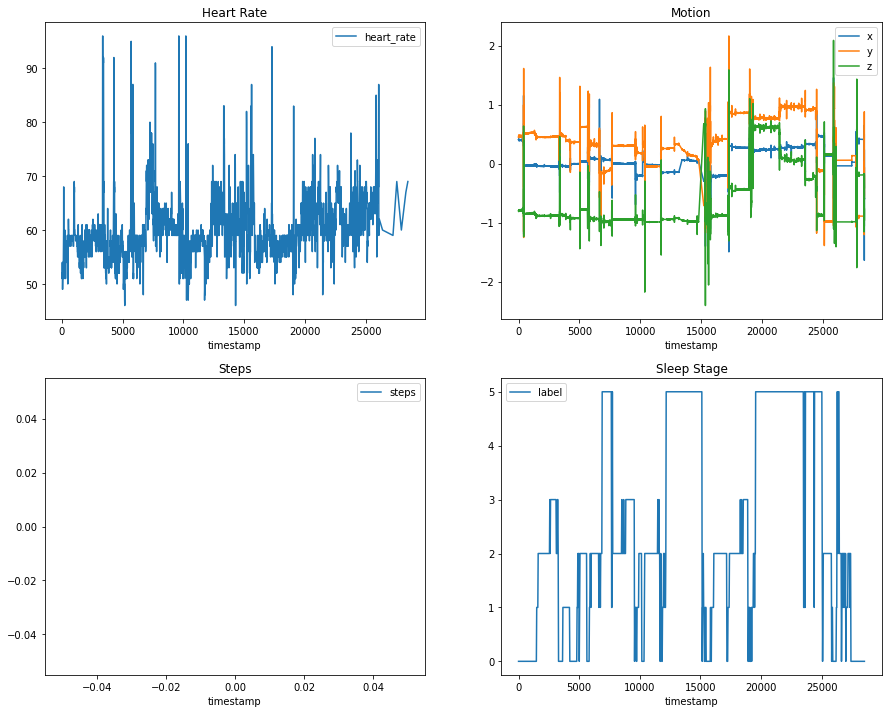

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

heart_df2.plot(x="timestamp", ax=ax[0, 0], title="Heart Rate")
motion_df2.plot(x="timestamp", ax=ax[0, 1], title="Motion")
steps_df2.plot(x="timestamp", ax=ax[1, 0], title="Steps")
labels_df.plot(x="timestamp", ax=ax[1, 1], title="Sleep Stage")

There is no steps data present during the PSG period, which intuitively makes sense as the subject is likely not walking while they're sleeping!

## Resampling

In [ ]:
print(heart_df2.shape)
print(motion_df2.shape)
print(labels_df.shape)

(4964, 2)
(1187903, 4)
(952, 2)


As can be seen from the number of samples in each DataFrame above, the data is sampled at different sampling rates across the different physiological signals over the 8 hour PSG period. In order to make all of the measurements synchronous, we need to resample the data. 

We chose to resample all of the data to 1Hz, so that we have a sample for every second. We interpolate between the two nearest values where gaps are present in the data.

In [ ]:
def resample(df, hz):
  df = df.copy()
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
  df.set_index("timestamp", inplace=True)

  new_index = pd.date_range(0, df.index.max(), freq=f"{1000/hz:.0f}ms")
  df_resampled = df.reindex(df.index.union(new_index)).interpolate().reindex(new_index)

  return df_resampled

In [ ]:
heart_df3 = resample(heart_df2, 1).reset_index().rename(columns={"index": "timestamp"})
motion_df3 = resample(motion_df2, 1).reset_index().rename(columns={"index": "timestamp"})
labels_df3 = resample(labels_df, 1).reset_index().rename(columns={"index": "timestamp"})

Visualising the resampled data...

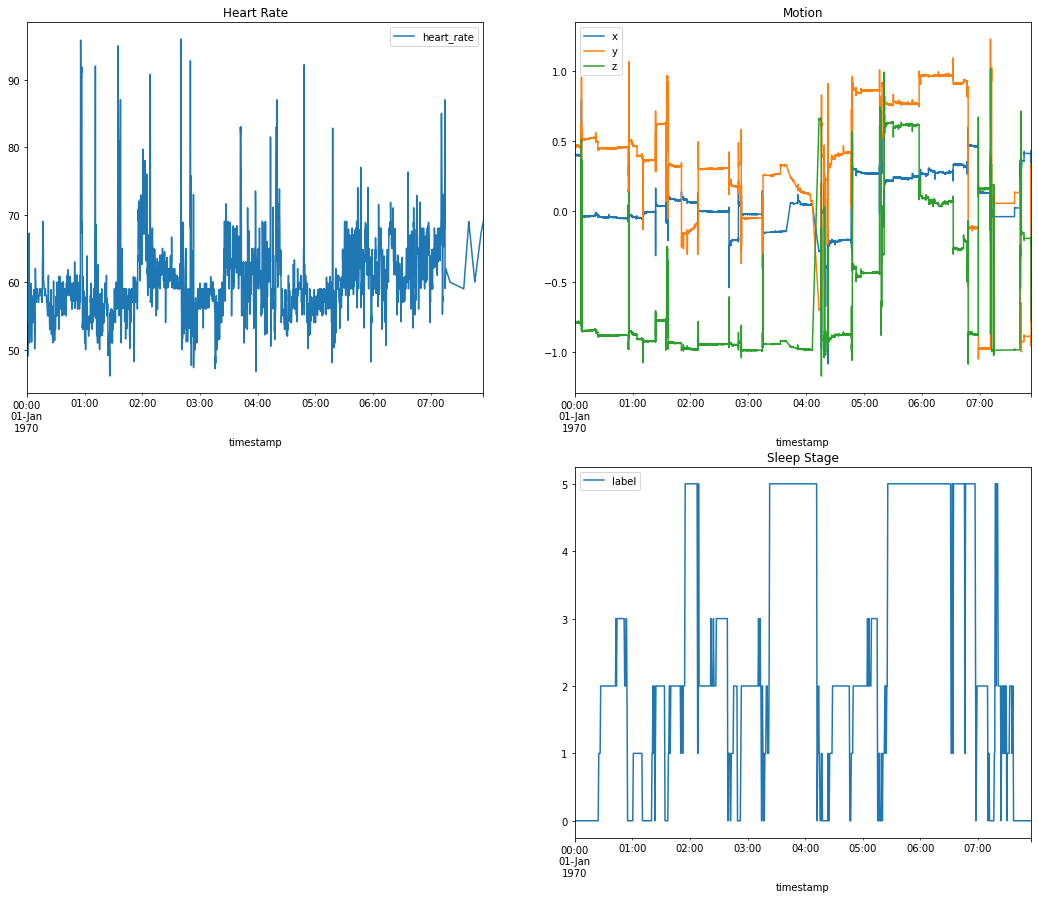

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 15))

heart_df3.plot(x="timestamp", ax=ax[0, 0], title="Heart Rate")
motion_df3.plot(x="timestamp", ax=ax[0, 1], title="Motion")

# No steps data present in the labelled range
ax[1, 0].set_visible(False)

labels_df3.plot(x="timestamp", ax=ax[1, 1], title="Sleep Stage")

Now that we have resampled the data for one subject, to prepare the data for training, we must crop and resample the data for all subjects.

Below we define our preprocessing pipeline and replicate the above process across all subjects.

## Preprocessing Pipeline

As well as processing and loading in the raw data for each subject, we are going to load in some of the features which Walch et. al outlined in [1]. These features were obtained through running the code in the Github repository associated with the paper, available [here](https://github.com/ojwalch/sleep_classifiers). The features considered in the paper which we intend to use are:

*   **"*Clock proxy*" feature** $\Rightarrow$ This feature served to approximate the changing drive of the circadian clock to sleep over the course of the night. This was implemented using a fixed cosine wave, shifted relative to the time of recording start, which rose and fell over the course of the night [1].
*   **Activity count feature** $\Rightarrow$ Walch et. al converted the raw acceleration data to activity counts using MATLAB code available in the aformentioned Github repository. This code was validated in [2] by Lindert et. al.

The function below loads in these features.



In [ ]:
def load_author_data(data_folder, subject):
  cosine = pd.read_csv(os.path.join(data_folder, f"{subject}_cosine_feature.out"), header=None, names=["cosine"])
  heart_rate = pd.read_csv(os.path.join(data_folder, f"{subject}_hr_feature.out"), header=None, names=["heart_rate"])
  count = pd.read_csv(os.path.join(data_folder, f"{subject}_count_feature.out"), header=None, names=["count"])

  time = pd.read_csv(os.path.join(data_folder, f"{subject}_time_feature.out"), header=None, names=["time"]) # Time in hours
  time["timestamp"] = pd.to_datetime((time["time"]*60*60).apply(lambda t: int(round(t))), unit="s") # Convert to timestamp in seconds
  
  psg = pd.read_csv(os.path.join(data_folder, f"{subject}_psg_labels.out"), header=None, names=["psg_label"])

  subj_features = pd.concat([cosine, heart_rate, count, time, psg], axis=1)

  return subj_features

Next, we define a function to load, crop and resample the raw data. This function also loads in the relevant features from [1] using the *load_author_data* function in the previous cell. The data from [1] is also resampled so that it aligns with how we have processed the data so far.

In [ ]:
def load_and_preprocess(raw_data_folder, author_data_folder, subject, hz=1):
  ## RAW DATA
  # Load
  heart_df, motion_df, steps_df, labels_df = load_data(raw_data_folder,subject)

  # Crop
  heart_df, motion_df, steps_df = filter_df(heart_df, motion_df, steps_df, labels_df)

  # Resample
  resampled_dfs = []
  for df in [heart_df, motion_df, steps_df, labels_df]:
    if len(df) == 0:
      resampled_dfs.append(pd.DataFrame(columns=df.columns))
      continue

    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df.set_index("timestamp", inplace=True)

    new_index = pd.date_range(0, df.index.max(), freq=f"{1000/hz:.0f}ms")
    df_resampled = df.reindex(df.index.union(new_index)).interpolate().reindex(new_index)

    resampled_dfs.append(df_resampled)


  # Merge
  df = resampled_dfs[0]
  for _df in resampled_dfs[1:]:
    df = df.merge(_df, how="outer", left_index=True, right_index=True)

  ## AUTHOR DATA
  # Load
  auth_df = load_author_data(author_data_folder, subject)

  # Resample
  auth_df.set_index("timestamp", inplace=True)
  new_index = pd.date_range(0, auth_df.index.max(), freq=f"{1000/hz:.0f}ms")
  auth_df_resampled = auth_df.reindex(auth_df.index.union(new_index)).interpolate().reindex(new_index)

  # Merge
  df = df.merge(auth_df_resampled.drop(columns=["heart_rate", "psg_label"]), left_index=True, right_index=True)


  # Clean
  df = df.iloc[1:-1].reset_index().rename(columns={"index": "timestamp"})
  df = df.dropna(subset=["heart_rate", "x", "y", "z"])[["timestamp", "heart_rate", "x", "y", "z", "cosine", "time", "count", "label"]]
  df["label"] = df["label"].round().astype(int)
  df = df[df["label"] != -1]

  return df

As a final step in preproccesing, we drop timestamps which have null values in either the heart rate or motion columns. We also round the sleep labels to the nearest whole number due to interpolation. These steps can be seen in the *Clean* step above.

The below function preprocesses the data for all subjects and writes the processed data to a new CSV file.

In [ ]:
def preprocess_all(raw_data_folder, author_data_folder, output_folder, hz=1):
  os.makedirs(output_folder, exist_ok=True)
  subjects = sorted(int(f.split("_")[0]) for f in os.listdir(os.path.join(raw_data_folder, "heart_rate")) if f.endswith(".txt"))

  for subject in subjects:
    print("Subject:", subject)
    df = load_and_preprocess(raw_data_folder, author_data_folder, subject, hz=hz)
    df.to_csv(os.path.join(output_folder, f"{subject}.csv"), index=False)

The below step is commented out as the files have already been processed and are stored in the 'dev/data/preprocessed_1hz' folder.

In [ ]:
# preprocess_all("sleep_classifiers/data", "sleep_classifiers/outputs/features", "dev/data/preprocessed_1hz", hz=1)

Subject: 46343
Subject: 759667
Subject: 781756
Subject: 844359
Subject: 1066528
Subject: 1360686
Subject: 1449548
Subject: 1455390
Subject: 1818471
Subject: 2598705
Subject: 2638030
Subject: 3509524
Subject: 3997827
Subject: 4018081
Subject: 4314139
Subject: 4426783
Subject: 5132496
Subject: 5383425
Subject: 5498603
Subject: 5797046
Subject: 6220552
Subject: 7749105
Subject: 8000685
Subject: 8173033
Subject: 8258170
Subject: 8530312
Subject: 8686948
Subject: 8692923
Subject: 9106476
Subject: 9618981
Subject: 9961348


## Segmenting the Data into Windows

To turn the data into something usable for training, we need to segment the data into windows. We decided to use 30 second windows and discard any data which does not fit. We assign a single label for each window, which is the most frequently occuring label in that window.

The function below segments the data into 30 second windows and returns a DataFrame of the features (x) and the target (y).

In [ ]:
def split_data(df, segment_length=30):
  # Split the data into 
  xs = []
  ys = []
  for i in range(0, len(df), segment_length):
    _df = df.iloc[i:i + segment_length].copy()
    _df["segment_id"] = i

    # Make sure segment is the right length
    if len(_df) == segment_length:
      xs.append(_df.drop(columns=["timestamp", "label"]))

      segment_label = _df["label"].value_counts().idxmax()
      ys.append(segment_label)

  x = pd.concat(xs)
  y = np.array(ys)

  return x, y

Next, we use the function above to segment the preprocessed data and we then concatenate the data for each subject together to form our training data (x) and targets (y), below.

In [ ]:
folder = "./dev/data/preprocessed_1hz"

xs = []
ys = []
cur_id = 0
for file in os.listdir(folder):
  print(file)

  # Load
  df = pd.read_csv(os.path.join(folder, file))
  df["subject"] = int(file.split(".")[0])

  # Split
  x , y = split_data(df)
  x["segment_id"] += cur_id
  cur_id = x["segment_id"].max() + 30

  xs.append(x)
  ys.append(y)

x = pd.concat(xs)

y = np.concatenate(ys)
label_df = pd.DataFrame()
label_df["segment_id"] = x["segment_id"].unique()
label_df["label"] = y

46343.csv
759667.csv
781756.csv
844359.csv
1066528.csv
1360686.csv
1449548.csv
1455390.csv
1818471.csv
2598705.csv
2638030.csv
3509524.csv
3997827.csv
4018081.csv
4314139.csv
4426783.csv
5132496.csv
5383425.csv
5498603.csv
5797046.csv
6220552.csv
7749105.csv
8000685.csv
8173033.csv
8258170.csv
8530312.csv
8686948.csv
8692923.csv
9106476.csv
9618981.csv
9961348.csv


This leaves us with clean data suitable for training after some feature engineering.

In [ ]:
x.drop(columns="timestamp.1", inplace=True)

In [ ]:
x.head()

,heart_rate,x,y,z,cosine,time,count,subject,segment_id
0,90.0,-0.300430,0.906998,0.339706,-0.285060,0.104166,0.003285,46343,0
1,90.0,-0.216530,0.926559,0.323997,-0.285130,0.104444,0.003099,46343,0
2,90.0,-0.136658,0.943542,0.325096,-0.285200,0.104722,0.002913,46343,0
3,90.0,-0.214668,0.946190,0.289070,-0.285270,0.105000,0.002727,46343,0
4,90.0,0.075783,0.659515,-0.054016,-0.285339,0.105278,0.002542,46343,0


In [ ]:
x.shape

(762660, 9)

In [ ]:
label_df.sample(10)

,segment_id,label
13833,414990,2
8226,246780,2
20713,621390,2
2887,86610,1
17096,512880,0
25305,759150,1
23299,698970,2
1022,30660,0
17113,513390,0
5696,170880,0


In [ ]:
y = label_df
y.set_index('segment_id', inplace=True)
y = y['label']
y.shape

(25422,)

# 2. Feature Engineering
---

The next step in the process is to choose the features which we will use for classification.

In [ ]:
x.shape

(762660, 9)

In [ ]:
y.head(5)

segment_id
0      0
30     0
60     0
90     0
120    0
Name: label, dtype: int64

## Feature Creation

### Manual

Here we manually create some extra features. These are features that would not be able to be derived automatically by just looking at the numbers and would usually require some domain knowledge.  

We calculate the magnitude of the accelerometer. This will simplify the three x/y/z accelerations into a single number that represents how much the subject is moving regardless of direction. For someone lying still, we would expect this to have a value of 1 which is the effect of gravity.  

$$acceleration = \sqrt{x^2 + y^2 + z^2}$$

In [ ]:
# Magnitude of the accelerometer vector
x["acceleration"] = (x["x"] ** 2 + x["y"] ** 2 + x["z"] ** 2) ** 0.5

# Remove the raw gyroscope features
x.drop(columns=["x", "y", "z"], inplace=True)

### TSFEL

We used the [Time Series Feature Extraction Library (TSFEL)](https://github.com/fraunhoferportugal/tsfel) to extract features from our data. This package computes a large number of statistical, temporal and spectral features from the data automatically. It calculates features on a window-level, meaning that we collapse the window of length 30 seconds into a single vector of features. The features computed capture many aspects of the time series, so we effectively remove the need to account for this in our models, treating the features as independent data points.  

In [ ]:
def fill_missing_values(df: pd.DataFrame):
    # Replace missing or inf values in the dataframe
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df.dropna(axis=1, inplace=True)
    return df

In [ ]:
def extract_features(df):
  # Turn dataframe into list of windows which is the required format for TSFEL
  ids = []
  windows = []
  for id, group in df.groupby("segment_id"):
    ids.append(id)
    windows.append(group.drop(columns=["subject", "segment_id"]))

  # Extract features
  feature_settings = tsfel.get_features_by_domain()
  features = tsfel.time_series_features_extractor(feature_settings, windows)
  features = fill_missing_values(features)
  
  # Set dataframe index
  features["segment_id"] = ids
  features.set_index("segment_id", inplace=True)
  
  return features

Note: The extraction process takes upwards of an hour for the entire dataset. We wrote the extracted features to a CSV file and they are loaded in here. 

In [ ]:
#features = extract_features(x)
#features.to_csv("./dev/data/1hz_x_features_tsfel_new2.csv") # Save features for quicker use later

features = pd.read_csv("./dev/data/1hz_x_features_tsfel_new2.csv", index_col=0) # Reading in previously extracted features

print("Num features calculated:", len(features.columns))
features.head(5)

Num features calculated: 750


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF Slope,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,0_ECDF_6,0_ECDF_7,0_ECDF_8,0_ECDF_9,0_Entropy,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_Fundamental frequency,0_Histogram_0,0_Histogram_1,0_Histogram_2,...,4_Total energy,4_Variance,4_Wavelet absolute mean_0,4_Wavelet absolute mean_1,4_Wavelet absolute mean_2,4_Wavelet absolute mean_3,4_Wavelet absolute mean_4,4_Wavelet absolute mean_5,4_Wavelet absolute mean_6,4_Wavelet absolute mean_7,4_Wavelet absolute mean_8,4_Wavelet energy_0,4_Wavelet energy_1,4_Wavelet energy_2,4_Wavelet energy_3,4_Wavelet energy_4,4_Wavelet energy_5,4_Wavelet energy_6,4_Wavelet energy_7,4_Wavelet energy_8,4_Wavelet entropy,4_Wavelet standard deviation_0,4_Wavelet standard deviation_1,4_Wavelet standard deviation_2,4_Wavelet standard deviation_3,4_Wavelet standard deviation_4,4_Wavelet standard deviation_5,4_Wavelet standard deviation_6,4_Wavelet standard deviation_7,4_Wavelet standard deviation_8,4_Wavelet variance_0,4_Wavelet variance_1,4_Wavelet variance_2,4_Wavelet variance_3,4_Wavelet variance_4,4_Wavelet variance_5,4_Wavelet variance_6,4_Wavelet variance_7,4_Wavelet variance_8,4_Zero crossing rate
segment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,254998.127273,26.693000,254998.127273,0.150123,6.0,24.0,90.0,94.909091,0.076389,0.033333,0.066667,0.1,0.133333,0.166667,0.2,0.233333,0.266667,0.3,0.333333,0.490114,0.010409,1.757253,0.000749,0.000019,0.000144,0.000052,0.000019,0.000045,0.410997,0.037564,0.021717,0.014029,0.005171,0.006759,0.002911,0.001039,3.571429,0.0,0.0,0.0,...,107.880404,0.019875,0.053851,0.160240,0.293276,0.460427,0.701716,1.052348,1.474417,1.901373,2.286547,0.212106,0.342057,0.417077,0.561922,0.783051,1.111275,1.522784,1.948301,2.335973,1.905656,0.205156,0.302202,0.296551,0.322123,0.347511,0.357065,0.380746,0.425038,0.477985,0.042089,0.091326,0.087942,0.103763,0.120764,0.127495,0.144968,0.180658,0.228470,0.0
30,307954.415152,29.380333,307954.415152,0.145850,6.0,24.0,101.0,101.727273,0.458333,0.033333,0.066667,0.1,0.133333,0.166667,0.2,0.233333,0.266667,0.3,0.333333,0.637904,0.000007,0.041238,0.000002,0.000004,0.000001,0.000003,0.000004,0.000007,0.006977,0.001826,0.001042,0.000366,0.000367,0.000158,0.000063,0.000018,3.571429,0.0,0.0,0.0,...,99.613429,0.006391,0.054604,0.161282,0.296756,0.461354,0.690797,1.022494,1.423103,1.829666,2.197289,0.186767,0.315584,0.460737,0.620134,0.811819,1.098804,1.472566,1.868838,2.234955,1.901806,0.178606,0.271259,0.352440,0.414390,0.426438,0.402339,0.378455,0.380629,0.408586,0.031900,0.073582,0.124214,0.171719,0.181850,0.161876,0.143228,0.144879,0.166943,0.0
60,256256.534444,26.742167,256256.534444,0.137049,6.0,24.0,89.0,96.000000,0.059524,0.033333,0.066667,0.1,0.133333,0.166667,0.2,0.233333,0.266667,0.3,0.333333,0.741494,0.108735,2.953884,0.002471,0.000191,0.000096,0.000250,0.000031,0.000013,0.534045,0.192265,0.051303,0.011831,0.012648,0.003698,0.003771,0.002760,3.571429,0.0,0.0,0.0,...,102.833908,0.001270,0.054397,0.161042,0.297564,0.463446,0.697133,1.037118,1.448266,1.865491,2.242641,0.161969,0.305999,0.450769,0.590799,0.785825,1.095643,1.492659,1.906511,2.285247,1.867703,0.152561,0.260194,0.338597,0.366417,0.362666,0.353298,0.361325,0.393355,0.439218,0.023275,0.067701,0.114648,0.134261,0.131527,0.124819,0.130556,0.154728,0.192912,0.0
90,202774.421111,23.823000,202774.421111,0.142614,6.0,24.0,81.0,82.666667,0.000000,0.033333,0.066667,0.1,0.133333,0.166667,0.2,0.233333,0.2

## Splitting the Data

We split the data into training, development and test sets. We chose to split based on each subject and not based on each segment because if the segments from one subject were split across each set, it could leak information from the test set into the training set. This ensures that we are testing the generalisability of the models not just to unseen data, but to unseen data from unseen subjects.  

There are 3 steps to this splitting process:  

- Split subjects into train / dev / test sets
- Split segments associated with the subjects
- Split x and y data associated with the segments

In [ ]:
random_seed = 0 #@param {type:"integer"}
dev_size = 0.15 #@param {type:"number"}
test_size = 0.15 #@param {type:"number"}


## Split by subject
# Divide subjects
subjects = x["subject"].unique()
subj_train, subj_test = train_test_split(subjects, test_size=test_size, shuffle=True, random_state=random_seed)
subj_train, subj_dev = train_test_split(subj_train, test_size=dev_size / (1 - test_size), shuffle=True, random_state=random_seed)

# Divide segments
seg_train = x.loc[x["subject"].isin(set(subj_train)), "segment_id"].unique()
seg_dev = x.loc[x["subject"].isin(set(subj_dev)), "segment_id"].unique()
seg_test = x.loc[x["subject"].isin(set(subj_test)), "segment_id"].unique()

## Split by segment directly
# # Divide segments
# segments = y.index.unique()
# seg_train, seg_test = train_test_split(segments, test_size=test_size, shuffle=True, random_state=random_seed)
# seg_train, seg_dev = train_test_split(seg_train, test_size=dev_size / (1 - test_size), shuffle=True, random_state=random_seed)

# Divide input data
x_train = features.loc[seg_train]
x_dev = features.loc[seg_dev]
x_test = features.loc[seg_test]

# Divide target data
y_train = y.loc[seg_train]
y_dev = y.loc[seg_dev]
y_test = y.loc[seg_test]

# Print split statistics
print("Data splits:")
print("Train:", len(x_train), "segments,", len(subj_train), "subjects")
print("Dev:", len(x_dev), "segments,", len(subj_dev), "subjects")
print("Test:", len(x_test), "segments,", len(subj_test), "subjects")

Data splits:
Train: 17090 segments, 21 subjects
Dev: 4079 segments, 5 subjects
Test: 4253 segments, 5 subjects


## Scaling the features

Some of the algorithms are sensitive to the scales of the input features, so we normalise them based on what we see in the training data. Each feature is normalised using the [Standard Score](https://en.wikipedia.org/wiki/Standard_score) given by:  
$$z = \frac{x - \mu}{\sigma}$$  

Where $\mu$ is the mean and $\sigma$ is the standard deviation. After they are scaled, each feature will have a mean of 0 and standard deviation of 1.

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
x_train_s = scaler.transform(x_train)
x_dev_s = scaler.transform(x_dev)
x_test_s = scaler.transform(x_test)

# 3. Regression
---

One way to approach the problem is as a regression task. While the labels given to us were categorical, we can treat them as a measure of how deep a subject is sleeping (from awake (0) to REM sleep (5)).  
For this task, we try several different models with different levels of complexity:  
  - Linear Regression
  - Random Forest Regression
  - Neural Network Regression

## Linear Regression

Linear regression is the simplest form of regression. It tries to fit a straight line as a linear function of the input features in order to predict a single target value.  

The model is trained using [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) which minimises the sum of the squares of the differences between the ground truth and predicted value.  

Once trained, the predictor function is given by:  
$$y = \sum_{i=0}^{n} w_i x_i + b$$  
Where $n$ is the number of input features, $w_i$ is the learned feature weight and $b$ is a bias or y-intercept term.  

We evaluate the model using the [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$) which measures the proportion of variance in ground truth value which is explained by our predicted value. A value of 1 means a perfect fit, 0 means the same performance as a "dumb" prediction of the modal value in the data, and anything below that indicates that the model may have overfit.  

In [ ]:
lr = LinearRegression().fit(x_train_s, y_train)
print("R^2 on training:", lr.score(x_train_s, y_train))
print("R^2 on dev:", lr.score(x_dev_s, y_dev))
print("R^2 on test:", lr.score(x_test_s, y_test))

R^2 on training: 0.2526184646845505
R^2 on dev: -3994803269030343.5
R^2 on test: -5.0396822288692945e+19


As expected, the model performs best on the training set. The extreme negative values on the dev and test sets indicate that the model has way overfit, which is not surprising due to the number of degrees of freedom which the LR model has.

If we look at the size of the weights that the model learned, there are a few with very large magnitudes and many with zero or close to zero. This is another indication that the model may have overfit on the training data, as small changes in those highly weighted features will lead to huge changes in predictions.  

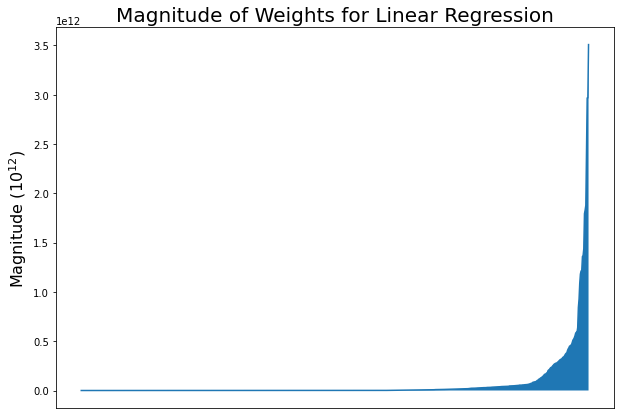

In [ ]:
x_ticks = np.arange(lr.coef_.shape[0])
magnitudes = np.sort(np.abs(lr.coef_.ravel()))


fig, ax = plt.subplots(figsize=(10, 7))
sn.lineplot(x=x_ticks, y=magnitudes, ax=ax)

# Formatting
plt.fill_between(x_ticks, magnitudes)

plt.title("Magnitude of Weights for Linear Regression", fontsize=20)
plt.ylabel("Magnitude ($10^{12}$)", fontsize=16)
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)


plt.show()

When we look at a handful of the top weighted features, we see that there is mostly a good mix of statistical, temporal and spectral features.

Note: the leading number of these feature names are the index of the original feature of the dataset (0: heart rate, 1: clock proxy, 2: time, 3: activity count, 4: acceleration).

In [ ]:
mag_df = pd.DataFrame()
mag_df["feature"] = x_train.columns
mag_df["weight"] = lr.coef_.ravel()
mag_df["magnitude"] = mag_df["weight"].abs()
mag_df.sort_values("magnitude", ascending=False, inplace=True)
mag_df.drop(columns="magnitude", inplace=True)
mag_df.head(20)

,feature,weight
710,4_Total energy,-3.507792e+12
96,0_Spectral centroid,2.966758e+12
105,0_Spectral slope,-2.966758e+12
600,4_Absolute energy,2.422269e+12
10,0_ECDF_1,-1.877165e+12
12,0_ECDF_3,-1.829694e+12
447,2_Wavelet variance_7,-1.792547e+12
445,2_Wavelet variance_5,1.437999e+12
444,2_Wavelet variance_4,-1.369740e+12
9,0_ECDF_0,-1.358043e+12


When we plot the ground truth against the predicted values for the three sets (train, dev and test), we see that the model does not perform well on the dev and test sets and has mostly learned to predict the 'awake' class of 0.

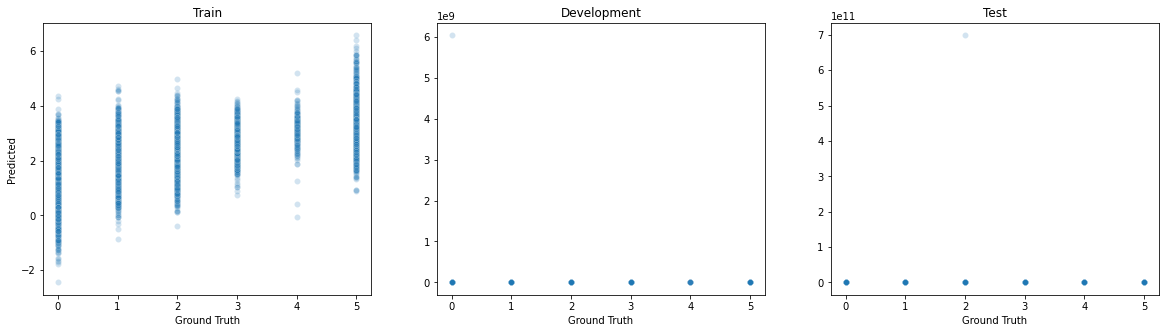

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
for i, (_x, _y, title) in enumerate(zip(
    [x_train_s, x_dev_s, x_test_s], 
    [y_train, y_dev, y_test],
    ["Train", "Development", "Test"]
    )):

  sn.scatterplot(x=_y.values.ravel(), y=lr.predict(_x).ravel(), alpha=0.2, ax=ax[i])
  ax[i].set_xlabel("Ground Truth")
  ax[i].set_title(title)

ax[0].set_ylabel("Predicted")

plt.show()

One technique to tackle this overfitting issue is regularization. Below, we try Elastic Net regularization for our Linear Regression model.

### Elastic Net

[Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization) regularisation is a method to penalise the magnitude of the weights learned by the linear regression model. This encourages the model to learn smaller weights, and leads to a more even distribution of sizes.  
The penalty is given by the formula:  
$$Penalty = \alpha r \sum_{i=0}^{n}|w_i| + \alpha (1 - r) * \sum_{i=0}^{n}w_i^2$$


The impact of the penalty is controlled by two parameters:
- $\alpha$: this controls how much weight is given to the penalty. A higher value penalises the model more. An $\alpha$ value of 0 is equivalent to a normal linear regression model.  
- $r$: this controls how much the penalty depends on the L1 norm (absolute value) and L2 norm (squared value) of the model weights.  

Both the $\alpha$ and $r$ are hyperparameters of the model that need to be tuned, which we will do later on.  

In [ ]:
a =  0.01 #@param {type:"number"}
r = 0.5 #@param {type:"number"}

en = ElasticNet(alpha=a, l1_ratio=r, normalize=False, max_iter=50000).fit(x_train_s, y_train)
print("R^2 on training:", en.score(x_train_s, y_train))
print("R^2 on dev:", en.score(x_dev_s, y_dev))
print("R^2 on test:", en.score(x_test_s, y_test))

R^2 on training: 0.16713208904562826
R^2 on dev: 0.13371995001621384
R^2 on test: 0.11202436297952267


While the performance on the training set has dropped, we have reduced the degree of overfitting on the dev and test sets considerably. The magnitudes of the weights have also come down to more reasonable ranges, from on the order of $10^{12}$ to less than 1.

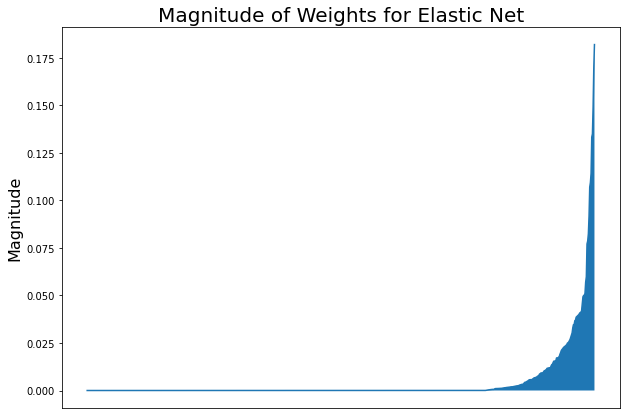

In [ ]:
x_ticks = np.arange(en.coef_.shape[0])
magnitudes = np.sort(np.abs(en.coef_.ravel()))


fig, ax = plt.subplots(figsize=(10, 7))
sn.lineplot(x=x_ticks, y=magnitudes, ax=ax)

# Formatting
plt.fill_between(x_ticks, magnitudes)

plt.title(f"Magnitude of Weights for Elastic Net", fontsize=20)
plt.ylabel("Magnitude", fontsize=16)
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)


plt.show()

The top features learned with elastic net are very different to those learned by the normal linear regression model. Again, there is a nice mix of all of the types of features. We also see a lot more spectral features than before, which shows that the model is learning the importance of properties intrinsic to time series data.

In [ ]:
mag_df = pd.DataFrame()
mag_df["feature"] = x_train.columns
mag_df["weight"] = en.coef_.ravel()
mag_df["magnitude"] = mag_df["weight"].abs()
mag_df.sort_values("magnitude", ascending=False, inplace=True)
mag_df.drop(columns="magnitude", inplace=True)
mag_df.head(20)

,feature,weight
197,1_Human range energy,0.181944
706,4_Spectral spread,-0.169395
541,3_Power bandwidth,-0.149084
106,0_Spectral spread,0.134937
47,0_Human range energy,-0.133253
342,2_Histogram_5,-0.114161
343,2_Histogram_6,-0.109353
555,3_Spectral slope,-0.106916
93,0_Signal distance,-0.091703
646,4_Histogram_9,0.082321


## Random Forest

[Random Forest](https://en.wikipedia.org/wiki/Random_forest) is an ensemble method which combines the predictions of many simple [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning). Each tree is trained on a random subset of the dataset, and all of the predictions are combined with an average.  
There are a number of hyperparameters for random forests, such as number of trees, tree depth/complexity, number of features for each tree, and so on. Each of these should be optimised for the dataset.  
In [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) Section 15.3, they propose default parameters as follows:
- Number of features per tree: $m = p / 3$ for regression tasks where $p$ is the number of features in the dataset.  
- Number of trees: $n = 200$ as a maximum, as they did not find signficiant improvement for values higher than this.  
- Minimum node size: 1

Since there is a lot of hyperparameters to tune, we will use these defaults and tune the others:
- Size of subset for each tree
- Complexity cost factor $\alpha$ (explained below)


In [ ]:
# Recommended defaults
proportion_features = 0.33 #@param {type:"number"}
num_trees =  200 #@param {type:"integer"}
min_node_size =  1 #@param {type:"integer"}

# Parameters to optimise
subset_size = 0.2 #@param {type:"number"}
ccp_alpha = 0.0 #@param {type:"number"}

rf = RandomForestRegressor(
  verbose=0, n_jobs=-1, 
  n_estimators=num_trees, 
  min_samples_leaf=min_node_size, 
  max_features=proportion_features,
  max_samples=subset_size,
  ccp_alpha=ccp_alpha
).fit(x_train_s, y_train.values.ravel())

print("R^2 on training:", rf.score(x_train_s, y_train.values.ravel()))
print("R^2 on dev:", rf.score(x_dev_s, y_dev.values.ravel()))
print("R^2 on test:", rf.score(x_test_s, y_test.values.ravel()))

R^2 on training: 0.6017774740597555
R^2 on dev: 0.07756870327775744
R^2 on test: 0.097423664883587


The results for the initial random forest show clear overfitting on the training data.

We can look at the importance of the features learned by the random forest. We'll use [Mean Decrease in Impurity (Gini Importance)](https://papers.nips.cc/paper/2013/file/e3796ae838835da0b6f6ea37bcf8bcb7-Paper.pdf) for this. This is analogous to the weights we examined for the linear regression models in that it measures the influence of the features on the predicted value. The features learned by our initial model seem to be mostly spread out, with some having zero importance and a handful having much higher importance.

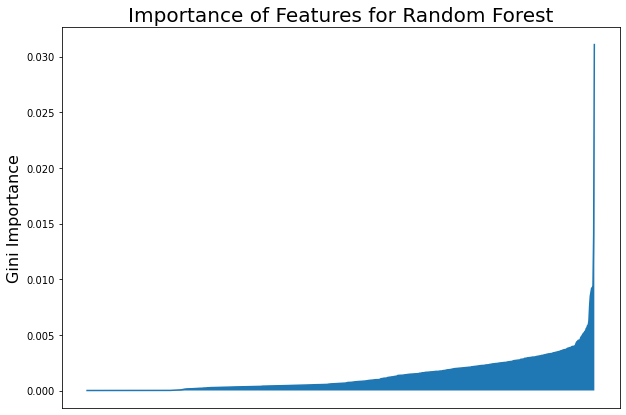

In [ ]:
x_ticks = np.arange(rf.feature_importances_.shape[0])
gini_importances = np.sort(rf.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 7))

# Gini
sn.lineplot(x=x_ticks, y=gini_importances, ax=ax)

# Formatting
plt.fill_between(x_ticks, gini_importances)

plt.title(f"Importance of Features for Random Forest", fontsize=20)
plt.ylabel("Gini Importance", fontsize=16)
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)

plt.show()

### Cost Complexity Pruning

Similar to the elastic net model, there are regularisation methods we can use for random forest. One method is [Cost Complexity Pruning](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning), which similarly adds a penalty for the complexity of the decision trees generated. Intuitively this means that the model will prefer a lower number of important features.   
It is parameterised by $\alpha \ge 0$ which needs to be optimised. An [example](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py) using CCP finds optimal $a$ of approximately 0.015, so we will start the search around this value. We will do more complete parameter tuning later on.

In [ ]:
# Recommended defaults
proportion_features = 0.33 #@param {type:"number"}
num_trees =  200 #@param {type:"integer"}
min_node_size =  1 #@param {type:"integer"}

# Parameters to optimise
subset_size = 0.2 #@param {type:"number"}
ccp_alpha = 0.015 #@param {type:"number"}

rf_ccp = RandomForestRegressor(
  verbose=0, n_jobs=-1, 
  n_estimators=num_trees, 
  min_samples_leaf=min_node_size, 
  max_features=proportion_features,
  max_samples=subset_size,
  ccp_alpha=ccp_alpha
).fit(x_train_s, y_train.values.ravel())

print("R^2 on training:", rf.score(x_train_s, y_train.values.ravel()))
print("R^2 on dev:", rf.score(x_dev_s, y_dev.values.ravel()))
print("R^2 on test:", rf.score(x_test_s, y_test.values.ravel()))

R^2 on training: 0.6017774740597555
R^2 on dev: 0.07756870327775744
R^2 on test: 0.097423664883587


The initial use of CCP doesn't seem to help with overfitting, possibly due to a bad selection for the $\alpha$ parameter. However, tuning of this parameter may produce better results.

Examining the importance of the individual features as done previously...

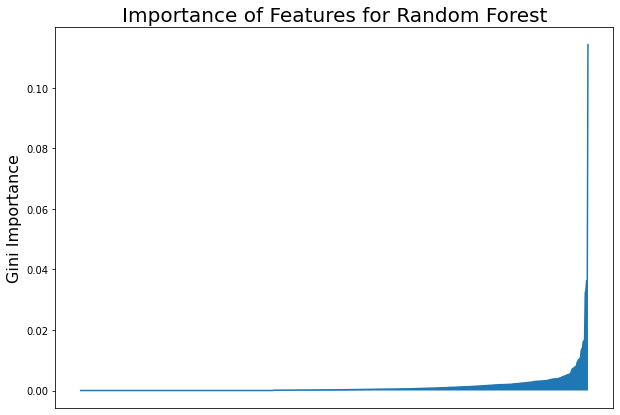

In [ ]:
x_ticks = np.arange(rf_ccp.feature_importances_.shape[0])
gini_importances = np.sort(rf_ccp.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 7))

# Gini
sn.lineplot(x=x_ticks, y=gini_importances, ax=ax)

# Formatting
plt.fill_between(x_ticks, gini_importances)

plt.title(f"Importance of Features for Random Forest", fontsize=20)
plt.ylabel("Gini Importance", fontsize=16)
plt.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)

plt.show()

As expected, we see that the importance of the features are clumped at the higher end, with most others being close to zero.

## Neural Network

[Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network) are the most complex type of model we're going to look at. Modelled loosely after biological neurons in the brain, neural networks are composed of many interconnected nodes. Each node takes the weighted sum of all previous nodes, followed by a non-linear (activation) function. The networks usually consist of many layers of neurons connected one after another. While each individual node is simple, neural networks can learn extremely complex tasks. We're going to use the most primitive type of neural network, called the [Multi-Layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), which has one or more "hidden" layers of nodes.  
Two components are required for the network to learn: a loss function and optimiser. The loss function takes the ground truth target and the network prediction and measures how far apart they are. The goal is to minimise this loss as much as possible. The optimiser takes the computed loss and uses it to update the model weights to minimise it. As the search space for the weights is far too large to be directly optimised, it is done in an iterative process called [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent). At each iteration, the weights are updated in the direction of steepest decline. The network training finishes when either a set number of iterations have passed, or improvement on the loss plateaus.  

We use the following configuration for our model:  
- Loss function: [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)
- Activation: [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)  
- Optimiser: [Adam](https://arxiv.org/abs/1412.6980)  
- [Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/): 256,  
- Hidden layer sizes: [100, 100]  
- Validation set for early stopping: 10% of training data


In [ ]:
nn = MLPRegressor(
  hidden_layer_sizes=(100, 100,),
  activation="relu",
  solver="adam",
  batch_size=256,
  validation_fraction=0.1,
  n_iter_no_change=100,
  max_iter=500,
  verbose=False,
  early_stopping=True
).fit(x_train_s, y_train.values.ravel())


print("R^2 on training:", nn.score(x_train_s, y_train.values.ravel()))
print("R^2 on dev:", nn.score(x_dev_s, y_dev.values.ravel()))
print("R^2 on test:", nn.score(x_test_s, y_test.values.ravel()))

R^2 on training: 0.24638464919830458
R^2 on dev: 0.07634026646892067
R^2 on test: 0.0661899211552015


We can observe how the training of the neural network went by looking at the how the loss and $R^2$ values change over time. 

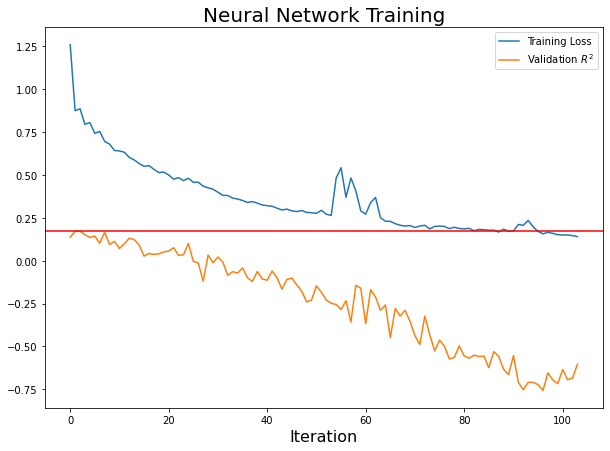

In [ ]:
df = pd.DataFrame()
df["Training Loss"] = nn.loss_curve_
df["Validation $R^2$"] = nn.validation_scores_

fig, ax = plt.subplots(figsize=(10, 7))
df.plot(ax=ax)
plt.axhline(max(nn.validation_scores_), c="r")

plt.title("Neural Network Training", fontsize=20)
plt.xlabel("Iteration", fontsize=16)
plt.show()

Over the course of training, the loss on the training data monotonically decreases. This is the goal of training and is expected. The $R^2$ on the validation data initially increases, but plateaus quickly at 5 iterations with a value of 0.2 (red line). After that it actually starts decreasing, which is a sign that the network has begun to overfit. Since the 10% of the data used for validation is randomly sampled from the training data, it does not generalise to the out of sample develop set and scores a poor $R^2$ value. 

# 4. Classification
---

For classification, we follow a similar progression in complexity as we did for regression.
- K-Nearest Neighbours Classifier
- Random Forest Classifier
- Neural Network Classifier

We used $R^2$ as the metrics to evaluate the performance of our regression models. As this is a measure of correlation, we cannot use this for classification. Instead, we use the [F1 Score](https://en.wikipedia.org/wiki/F-score) (or Dice Coefficient) which measures a balance between [Precision](https://en.wikipedia.org/wiki/Precision_and_recall) (Proportion of positive predictions which are correct) and [Sensitivity](https://en.wikipedia.org/wiki/Precision_and_recall) (Proportion of positive instances predicted correctly).  
The F1 score for class $i$ is given by:  
$$F1_i = \frac{2 * precision_i * sensitivity_i}{precision_i + sensitivity_i}$$  
$$precision = \frac{TP}{TP+FP}$$  
$$sensitivity = \frac{TP}{TP+FN}$$  

Where $TP$, $FP$, $FN$ are true positive, false positive and false negative values between the ground truth and predicted classes.  

The F1 score for a model is simply the average of the F1 scores for each class.  

Below, we define a function to plot the confusion matrix to aid in the evaluation of each algorithm also.

In [ ]:
def plot_cm(y_true, y_pred, title="Classifier Confusion Matrix"):
  # Function to plot a confusion matrix
  labels = np.unique(y_true)
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  
  plt.subplots(figsize=(10, 7))
  sn.heatmap(cm, annot=cm)

  plt.title(title, fontsize=20)
  plt.xlabel("Predicted", fontsize=16)
  plt.ylabel("Ground Truth", fontsize=16)

  plt.xticks(np.arange(len(labels)) + 0.5, labels)
  plt.yticks(np.arange(len(labels)) + 0.5, labels)
  plt.show()

## K-Nearest Neighbours

K-Nearest Neighbours is perhaps the simplest way of classifying data. To classify a data point, it selects the $K$ nearest data points from the training set, and assigns the most common class from those. Its only parameter is the number of neighbours $K$ to consider when classifying a data point.  
Unfortunately, even the fastest K-NN algorithm grows with $O(DlogN)$ complexity, where $D$ is the number of features and $N$ is the number of training samples. With our dataset of $D=750$ and $N \approx 17,000$, this classificiation method is not feasable. For completeness, the code is here to run it but we were not able to train it in a reasonable time.  

In [ ]:
k = 5 #@param {type:"integer"}
knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm="ball_tree").fit(x_train_s, y_train.values.ravel())

print("F1 on training:", f1_score(y_train.values.ravel(), knn.predict(x_train_s), average="macro"))
print("F1 on dev:", f1_score(y_dev.values.ravel(), knn.predict(x_dev_s), average="macro"))
print("F1 on test:", f1_score(y_test.values.ravel(), knn.predict(x_test_s), average="macro"))

## Random Forest Classifier

The Random Forest classifier is very similar to the regression model used above. This time the predicted class probabilities are averages across the forest, and the highest is taken as the predicted class.  

In [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) Section 15.3, they propose default parameters as follows:
- Number of features per tree: $m = \sqrt p$ for classification tasks where $p$ is the number of features in the dataset.  
- Number of trees: $n = 200$ as a maximum, as they did not find signficiant improvement for values higher than this.  
- Minimum node size: 5

Again, we fix these parameters, and optimise over the following:
- Size of subset for each tree
- Complexity cost factor $\alpha$

In [ ]:
# Recommended defaults
proportion_features = "sqrt"
# proportion_features = 0.33 #@param {type:"number"}
num_trees =  200 #@param {type:"integer"}
min_node_size =  5 #@param {type:"integer"}

# Parameters to optimise
subset_size = 0.2 #@param {type:"number"}
ccp_alpha = 0.0 #@param {type:"number"}

rf_cls = RandomForestClassifier(
  verbose=0, n_jobs=-1,
  n_estimators=num_trees, 
  min_samples_leaf=min_node_size, 
  max_features=proportion_features,
  max_samples=subset_size,
  ccp_alpha=ccp_alpha
  ).fit(x_train_s, y_train.values.ravel())

print("F1 on training:", f1_score(y_train.values.ravel(), rf_cls.predict(x_train_s), average="macro"))
print("F1 on dev:", f1_score(y_dev.values.ravel(), rf_cls.predict(x_dev_s), average="macro"))
print("F1 on test:", f1_score(y_test.values.ravel(), rf_cls.predict(x_test_s), average="macro"))

F1 on training: 0.6412738562118221
F1 on dev: 0.29718741573068475
F1 on test: 0.3010696335411699


Initially, the results of the classifier are promising: an F1 score of nearly 0.3. However when we visualise the confusion between the classes, it's clear that the model hasn't really learned anything. It's just classifying everything as non-REM level 2, which is the most common label in the dataset.  

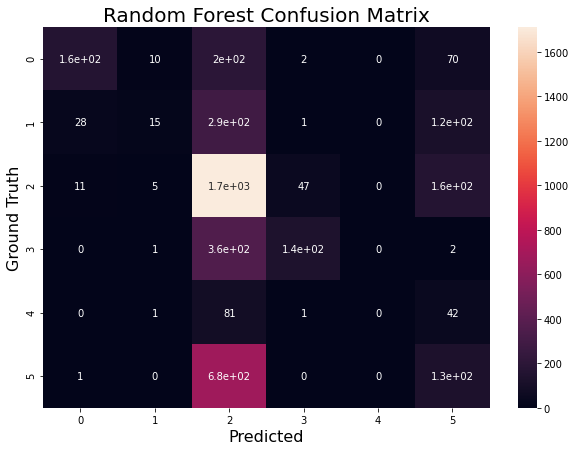

In [ ]:
pred = rf_cls.predict(x_test_s)
plot_cm(y_test, pred, title="Random Forest Confusion Matrix")

## Neural Network Classifier


The neural network classifier is very similar to its regression counterpart. The only difference is that this time we use the [Categorical Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function as we are predicting classes and not a scalar value.  
We use the following configuration for our model:  
- Loss function: Categorical Cross Entropy  
- Activation: [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)  
- Optimiser: [Adam](https://arxiv.org/abs/1412.6980)  
- [Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/): 256,  
- Hidden layer sizes: [100, 100]  
- Validation set for early stopping: 10% of training data

In [ ]:
"""
nn_cls = MLPClassifier(
  hidden_layer_sizes=(100, 100),
  activation="relu",
  solver="adam",
  batch_size=256,
  validation_fraction=0.1,
  n_iter_no_change=100,
  max_iter=500,
  verbose=False,
  early_stopping=True
).fit(x_train_s, y_train.values.ravel())
"""

print("F1 on training:", f1_score(y_train.values.ravel(), nn_cls.predict(x_train_s), average="macro"))
print("F1 on dev:", f1_score(y_dev.values.ravel(), nn_cls.predict(x_dev_s), average="macro"))
print("F1 on test:", f1_score(y_test.values.ravel(), nn_cls.predict(x_test_s), average="macro"))

F1 on training: 0.8696028684708672
F1 on dev: 0.28739184531452094
F1 on test: 0.29153509945863787


The neural network classifier performed no better than the random forest. It once again overfit to the training data extremely quickly, peaking at just under 70% accuracy on the validation data. We see that it once again classified everything as non-REM level 2, with an almost identical pattern to random forest. 

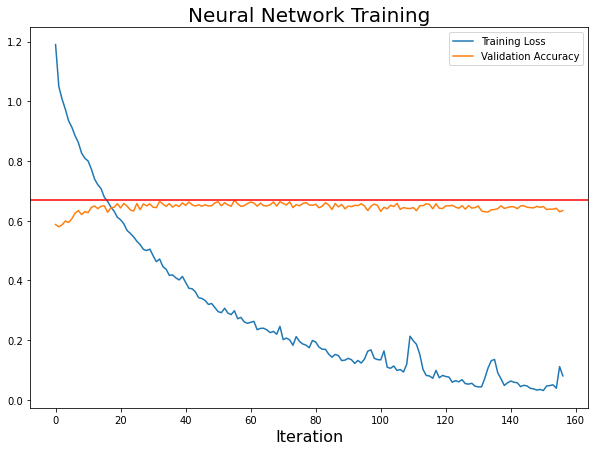

In [ ]:
df = pd.DataFrame()
df["Training Loss"] = nn_cls.loss_curve_
df["Validation Accuracy"] = nn_cls.validation_scores_

fig, ax = plt.subplots(figsize=(10, 7))
df.plot(ax=ax)
plt.axhline(max(nn_cls.validation_scores_), c="r")

plt.title("Neural Network Training", fontsize=20)
plt.xlabel("Iteration", fontsize=16)
plt.show()

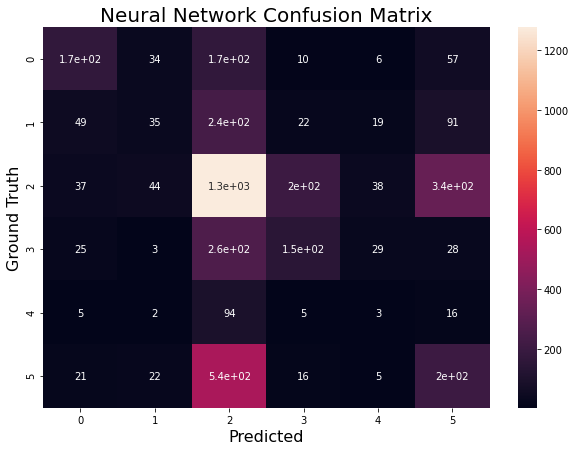

In [ ]:
pred = nn_cls.predict(x_test_s)
plot_cm(y_test, pred, title="Neural Network Confusion Matrix")

# 5. Validation of the models
---

While some of the models have built-in validation, such as neural networks, we wanted to ensure we tested each of the models thoroughly. For this we will use Nested Cross-Validation. First we split the subjects into $k_o$ train+dev and test sets. For each fold, we further split the train+dev sets into $k_i$ train and develop sets.  
In [this article](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/), they recommend values of $k_o = 10$ and $k_i = 5$, which means that for each model and each combination of parameters, we will be training and evaluating $k_o * k_i = 50$ times. This is quite a lot even for models with very few parameters, and this quickly skyrockets for more complex models. For example, for the brief parameter tuning for the random forests, we used 5 different data subset sizes, and 6 different cost complexity weights. This means that we would have to train and evaluate 1500 models!

In [ ]:
def nested_k_fold_split(data, outer_k=10, inner_k=3, random_seed=None):
  """
  Splits the data into k_o outer folds and k_i inner folds.
  Returns data sets as follows:
  [
    ([
      (train0, dev0),
      (train1, dev1),
      ...
    ], test0),
    ([...], test1),
    ([...], test2),
    ...
  ]
  """

  kfold_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_seed)
  kfold_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_seed)

  splits = []
  for train_dev, test in kfold_outer.split(data):

    td_splits = []
    for train, dev in kfold_inner.split(train_dev):
      td_splits.append((data[train], data[dev]))
    
    splits.append((td_splits, data[test]))

  return splits

In [ ]:
def select_and_prep_data(x, y, subj_train, subj_dev, subj_test):
  """
  Splits the segments based on given subjects and normalises them based on training set.
  """

  # Divide segments
  seg_train = x.loc[x["subject"].isin(set(subj_train)), "segment_id"].unique()
  seg_dev = x.loc[x["subject"].isin(set(subj_dev)), "segment_id"].unique()
  seg_test = x.loc[x["subject"].isin(set(subj_test)), "segment_id"].unique()

  # Divide input data
  x_train = features.loc[seg_train]
  x_dev = features.loc[seg_dev]
  x_test = features.loc[seg_test]

  # Divide target data
  y_train = y.loc[seg_train]
  y_dev = y.loc[seg_dev]
  y_test = y.loc[seg_test]

  # Normalise input data
  scaler = StandardScaler()
  scaler.fit(x_train)

  x_train_s = scaler.transform(x_train)
  x_dev_s = scaler.transform(x_dev)
  x_test_s = scaler.transform(x_test)
  
  return x_train_s, y_train.values.ravel(), \
        x_dev_s, y_dev.values.ravel(), \
        x_test_s, y_test.values.ravel()

In [ ]:
def grid_search(x_train, y_train, x_dev, y_dev, x_test, y_test, model, params, scoring_func, random_seed=0):
  """
  Performs grid search over a given parameter space.
  Returns results for all parameter combinations.
  """

  params = ParameterGrid(params)

  scores = []
  for i, param_set in enumerate(iter(params)):
    print("\tGrid search iter:", i + 1, "/", len(params))
    m = model(**param_set).fit(x_train, y_train)
    train_score = scoring_func(y_train, m.predict(x_train))
    dev_score = scoring_func(y_dev, m.predict(x_dev))
    test_score = scoring_func(y_test, m.predict(x_test))

    scores.append({
        **param_set,
        "train_score": train_score,
        "dev_score": dev_score,
        "test_score": test_score
    })

  return pd.DataFrame(scores)

In [ ]:
def nested_cross_validation(model, outer_k, inner_k, gridsearch_params, scoring_func, random_seed=0):
  """
  Performs nested cross validation for a given model and parameter search space.  
  Results for all folds and parameter combinations are returned.  
  """

  subject_splits = nested_k_fold_split(subjects, outer_k, inner_k, random_seed)

  start = time.time()
  results = []
  for i, (train_dev_split, test_split) in enumerate(subject_splits):
    for j, (train_split, dev_split) in enumerate(train_dev_split):

      print("Split:", i * inner_k + j + 1, "/", outer_k * inner_k)
      x_train, y_train, x_dev, y_dev, x_test, y_test = select_and_prep_data(x, y, train_split, dev_split, test_split)

      split_results = grid_search(x_train, y_train, x_dev, y_dev, x_test, y_test, model, gridsearch_params, scoring_func, random_seed)
      split_results["test_fold"] = i
      split_results["dev_fold"] = j
      results.append(split_results)

  end = time.time()
  print(f"Time taken: {end - start:.0f}s, ({(end - start)/(outer_k * inner_k):.1f}s/split)")

  return pd.concat(results).reset_index(drop=True)

### Regression

Since doing a large scale search for a complex model would probably take several days or weeks, we will use a smaller example to show the process in action. Here we use the same random forest regression model as we used previously, but with a smaller number of trees and smaller range of parameters to optimise. We will evaluate a total of 60 models.  

In [ ]:
# Nested cross validation parameters
k_inner =  2#@param {type:"integer"}
k_outer =  2#@param {type:"integer"}

proportion_features = 0.33 #@param {type:"number"}
num_trees =   10#@param {type:"integer"}
min_node_size =  1 #@param {type:"integer"}

# Parameters to optimise
candidate_subset_sizes = [0.2, 0.5, 0.8] #@param
candidate_ccp_alphas = [0.01, 0.05, 0.1, 0.5, 1] #@param


model = RandomForestRegressor
params = {
    "n_jobs": [-1],
    "n_estimators": [num_trees],
    "max_samples": [proportion_features],
    "min_samples_leaf": [min_node_size],
    "max_samples": candidate_subset_sizes,
    "ccp_alpha": candidate_ccp_alphas
}
reg_results = nested_cross_validation(model, k_outer, k_inner, params, r2_score)

Split: 1 / 4
	Grid search iter: 1 / 15
	Grid search iter: 2 / 15
	Grid search iter: 3 / 15
	Grid search iter: 4 / 15
	Grid search iter: 5 / 15
	Grid search iter: 6 / 15
	Grid search iter: 7 / 15
	Grid search iter: 8 / 15
	Grid search iter: 9 / 15
	Grid search iter: 10 / 15
	Grid search iter: 11 / 15
	Grid search iter: 12 / 15
	Grid search iter: 13 / 15
	Grid search iter: 14 / 15
	Grid search iter: 15 / 15
Split: 2 / 4
	Grid search iter: 1 / 15
	Grid search iter: 2 / 15
	Grid search iter: 3 / 15
	Grid search iter: 4 / 15
	Grid search iter: 5 / 15
	Grid search iter: 6 / 15
	Grid search iter: 7 / 15
	Grid search iter: 8 / 15
	Grid search iter: 9 / 15
	Grid search iter: 10 / 15
	Grid search iter: 11 / 15
	Grid search iter: 12 / 15
	Grid search iter: 13 / 15
	Grid search iter: 14 / 15
	Grid search iter: 15 / 15
Split: 3 / 4
	Grid search iter: 1 / 15
	Grid search iter: 2 / 15
	Grid search iter: 3 / 15
	Grid search iter: 4 / 15
	Grid search iter: 5 / 15
	Grid search iter: 6 / 15
	Grid search 

This gives us $R^2$ scores across every outer and inner fold, and every parameter combination.

In [ ]:
reg_results.sample(10)

,ccp_alpha,max_samples,min_samples_leaf,n_estimators,n_jobs,train_score,dev_score,test_score,test_fold,dev_fold
41,0.50,0.8,1,10,-1,-0.000001,-0.001486,-9.637828e-06,1,0
52,0.10,0.5,1,10,-1,0.110201,0.077262,9.095635e-02,1,1
16,0.01,0.5,1,10,-1,0.552915,0.083711,1.389665e-01,0,1
1,0.01,0.5,1,10,-1,0.675871,-0.002881,9.068381e-02,0,0
12,1.00,0.2,1,10,-1,-0.000074,-0.005470,-5.012717e-03,0,0
59,1.00,0.8,1,10,-1,-0.000018,-0.001779,-1.644545e-03,1,1
43,1.00,0.5,1,10,-1,-0.000134,-0.000673,-9.526102e-05,1,0
46,0.01,0.5,1,10,-1,0.569874,0.041572,1.612583e-01,1,1
36,0.10,0.2,1,10,-1,0.230258,0.032524,8.711704e-02,1,0
26,0.50,0.8,1,10,-1,-0.000037,-0.003757,-7.622591e-07,0,1


### Analysing the results

To boil down this amount of data into something manageable, we're going to have to do some aggregating. We'll do this in three stages:  
- For each outer fold and parameter combination, calculate the average model develop score across the inner folds.  
- For each outer fold, select the parameters with the highest average develop score.  
- Calculate the average test score across all of the outer folds.  

[Note](https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection) that this does not give us a single best model. This evaluates the model optimisation process, giving a measure of how well the model generalises to unseen data, and how suitable our chosen parameter search space is.  

In [ ]:
def aggregate_results(results, params):
  # Aggregate over inner folds
  inner_results = results.groupby(["test_fold", *params]).mean().reset_index().drop(columns="dev_fold")
  
  # Select the best model for each outer fold
  idx = inner_results.groupby("test_fold")["dev_score"].idxmax()
  best_per_outer_fold = inner_results.loc[idx].reset_index(drop=True)
  
  # Average over outer folds
  avg_outer = best_per_outer_fold.drop(columns=["test_fold", *params]).mean()

  # Select best parameters
  agg_param_results = results.groupby([*params]).mean().reset_index()
  best_params = agg_param_results.loc[agg_param_results["dev_score"].idxmax(), [*params]].to_dict()


  return avg_outer, best_params

The results for for random forest regression are not very good, however they do show that nested cross validation works. Instead of overfitting on the training set as we would with a single train/develop split, we end up with the results that generalise best to the unseen data.  

In [ ]:
agg_results, best_params = aggregate_results(reg_results, params.keys())
print("Best parameters:", best_params)
print("Average R^2 on training:", agg_results["train_score"])
print("Average R^2 on develop:", agg_results["dev_score"])
print("Average R^2 on test:", agg_results["test_score"])

Best parameters: {'n_jobs': -1.0, 'n_estimators': 10.0, 'max_samples': 0.8, 'min_samples_leaf': 1.0, 'ccp_alpha': 0.1}
Average R^2 on training: 0.39521236056675746
Average R^2 on develop: 0.07190819396029952
Average R^2 on test: 0.14927210907209146


We can also visualise the performance across the parameter space by averaging over all folds. This gives us a rough estimate for the location of optimal parameters. For the random forest, we can see that the optimal values for subset size and $\alpha$ are around 0.8 and 0.1 respectively. As this is across many folds, we can be confident that this represents the true optimal for unseen data.  

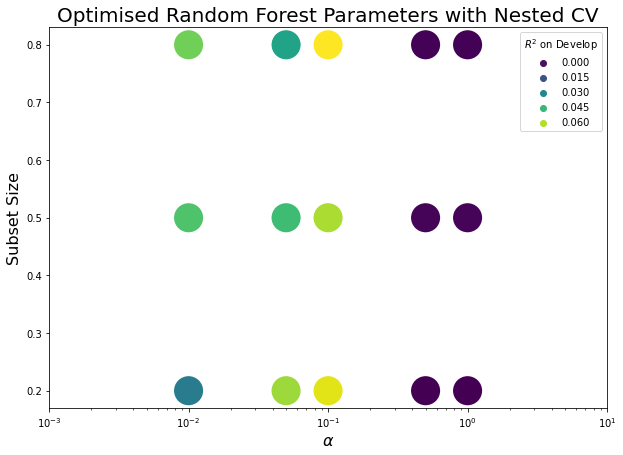

In [ ]:
plt.subplots(figsize=(10, 7))
sn.scatterplot(data=reg_results.groupby(["ccp_alpha", "max_samples"]).mean().reset_index(), x="ccp_alpha", y="max_samples", hue="dev_score", palette="viridis", s=1000)
plt.xscale("log")
plt.xlim((0.001, 10))

plt.title("Optimised Random Forest Parameters with Nested CV", fontsize=20)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.ylabel("Subset Size", fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), title=r"$R^2$ on Develop")

plt.show()

## Classification

We can do the exact same thing for the random forest classifier. Again we use slightly reduced parameters to speed things up.  

In [ ]:
def f1(gt, pred):
  return f1_score(gt, pred, average="macro")

In [ ]:
# Nested cross validation parameters
k_inner =  2#@param {type:"integer"}
k_outer =  2#@param {type:"integer"}

# proportion_features = 0.33 #@param {type:"number"}
proportion_features = "sqrt"
num_trees =   50#@param {type:"integer"}
min_node_size =  5 #@param {type:"integer"}

# Parameters to optimise
candidate_subset_sizes = [0.2, 0.4, 0.6] #@param
candidate_ccp_alphas = [0, 0.002, 0.005] #@param


model = RandomForestClassifier
params = {
    "n_jobs": [-1],
    "n_estimators": [num_trees],
    "max_samples": [proportion_features],
    "min_samples_leaf": [min_node_size],
    "max_samples": candidate_subset_sizes,
    "ccp_alpha": candidate_ccp_alphas
}
cls_results = nested_cross_validation(model, k_outer, k_inner, params, f1)

Split: 1 / 4
	Grid search iter: 1 / 9
	Grid search iter: 2 / 9
	Grid search iter: 3 / 9
	Grid search iter: 4 / 9
	Grid search iter: 5 / 9
	Grid search iter: 6 / 9
	Grid search iter: 7 / 9
	Grid search iter: 8 / 9
	Grid search iter: 9 / 9
Split: 2 / 4
	Grid search iter: 1 / 9
	Grid search iter: 2 / 9
	Grid search iter: 3 / 9
	Grid search iter: 4 / 9
	Grid search iter: 5 / 9
	Grid search iter: 6 / 9
	Grid search iter: 7 / 9
	Grid search iter: 8 / 9
	Grid search iter: 9 / 9
Split: 3 / 4
	Grid search iter: 1 / 9
	Grid search iter: 2 / 9
	Grid search iter: 3 / 9
	Grid search iter: 4 / 9
	Grid search iter: 5 / 9
	Grid search iter: 6 / 9
	Grid search iter: 7 / 9
	Grid search iter: 8 / 9
	Grid search iter: 9 / 9
Split: 4 / 4
	Grid search iter: 1 / 9
	Grid search iter: 2 / 9
	Grid search iter: 3 / 9
	Grid search iter: 4 / 9
	Grid search iter: 5 / 9
	Grid search iter: 6 / 9
	Grid search iter: 7 / 9
	Grid search iter: 8 / 9
	Grid search iter: 9 / 9
Time taken: 74s, (18.5s/split)


The results for our random forest classifier are slightly better. Instead of hovering around an F1 score of 0.22 which would be the equivalent of guessing the modal class all the time, it scores 0.31 on the develop set and 0.4 on the test set. We also get optimal parameters of a subset size of around 60% and $\alpha$ of 0.

In [ ]:
agg_results, best_params = aggregate_results(cls_results, params.keys())
print("Best params:", best_params)
print("Average F1 Score on training:", agg_results["train_score"])
print("Average F1 Score on develop:", agg_results["dev_score"])
print("Average F1 Score on test:", agg_results["test_score"])

Best params: {'n_jobs': -1.0, 'n_estimators': 50.0, 'max_samples': 0.6, 'min_samples_leaf': 5.0, 'ccp_alpha': 0.0}
Average F1 Score on training: 0.6274125877592915
Average F1 Score on develop: 0.3100551611880651
Average F1 Score on test: 0.40076385991138985


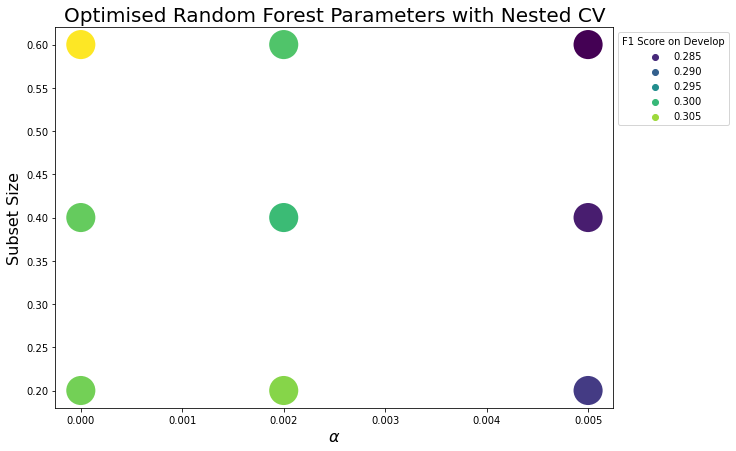

In [ ]:
plt.subplots(figsize=(10, 7))
sn.scatterplot(data=cls_results.groupby(["ccp_alpha", "max_samples"]).mean().reset_index(), x="ccp_alpha", y="max_samples", hue="dev_score", palette="viridis", s=1000)

plt.title("Optimised Random Forest Parameters with Nested CV", fontsize=20)
plt.xlabel(r"$\alpha$", fontsize=16)
plt.ylabel("Subset Size", fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), title=r"F1 Score on Develop")

plt.show()

## Comparing Models

This nested cross-validation approach lets us robustly compare different models and parameters. We can define our models and grids of parameters and let the exhaustive search run. 

**Note**: For some reason, probably due to the sheer size of the computation required to run the nested CV below, Google Colab did not finish the nested CV after two attempts to run it. It was originally run with substantially less features, so below, we discuss the results based on these features.

In [ ]:
save_folder = "dev/data/ncv_results"
os.makedirs(save_folder, exist_ok=True)

### Regression

In [ ]:
reg_model_params = [
  (LinearRegression, {
     "n_jobs": [-1],
   }),
   (ElasticNet, {
     "alpha": [0.001, 0.01, 0.1, 1],
     "l1_ratio": [0, 0.01, 0.1, 0.5, 0.9, 0.99, 1],
   }),
  (RandomForestRegressor, {
    "n_jobs": [-1],
    "n_estimators": [50, 100, 200],
    "max_samples": [0.333],
    "min_samples_leaf": [1],
    "max_samples": [0.1, 0.2, 0.5],
    "ccp_alpha": [0, 0.001, 0.01, 0.1, 1],
  }),
  (MLPRegressor, {
    "hidden_layer_sizes": [(8, 8), (16, 16), (32, 32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "batch_size": [16, 32, 64],
    "validation_fraction": [0.1],
    "max_iter": [100],
    "n_iter_no_change": [20],
    "early_stopping": [True]
  })
]

In [ ]:
# Nested cross validation parameters
k_inner =  5#@param {type:"integer"}
k_outer =  3#@param {type:"integer"}

all_reg_results = []
for model, params in reg_model_params:
  print(model.__name__)
  results = nested_cross_validation(model, k_outer, k_inner, params, r2_score)
  agg_results, best_params = aggregate_results(results, params.keys())

  results.to_csv(os.path.join(save_folder, f"{model.__name__}.csv"), index=False)

  all_reg_results.append((agg_results, best_params))
  print("Best params:", best_params)
  print("Average R^2 Score on training:", agg_results["train_score"])
  print("Average R^2 Score on develop:", agg_results["dev_score"])
  print("Average R^2 Score on test:", agg_results["test_score"])

LinearRegression
Split: 1 / 15
	Grid search iter: 1 / 1
Split: 2 / 15
	Grid search iter: 1 / 1
Split: 3 / 15
	Grid search iter: 1 / 1
Split: 4 / 15
	Grid search iter: 1 / 1
Split: 5 / 15
	Grid search iter: 1 / 1
Split: 6 / 15
	Grid search iter: 1 / 1
Split: 7 / 15
	Grid search iter: 1 / 1
Split: 8 / 15
	Grid search iter: 1 / 1
Split: 9 / 15
	Grid search iter: 1 / 1
Split: 10 / 15
	Grid search iter: 1 / 1
Split: 11 / 15
	Grid search iter: 1 / 1
Split: 12 / 15
	Grid search iter: 1 / 1
Split: 13 / 15
	Grid search iter: 1 / 1
Split: 14 / 15
	Grid search iter: 1 / 1
Split: 15 / 15
	Grid search iter: 1 / 1
Time taken: 24s, (1.6s/split)
Best params: {'n_jobs': -1.0}
Average R^2 Score on training: 0.3036601738366783
Average R^2 Score on develop: -4.910313728050515e+19
Average R^2 Score on test: -5.812941814389794e+18
ElasticNet
Split: 1 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11660.721363276702, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11336.079195990726, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8918.876966065194, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3651.098952904138, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.6377859532331, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.16243113555902, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.36634603581842, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11798.921765633437, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9402.382778857736, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 892.5999301631236, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12061.687658493141, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1128.5681285383616, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12539.970155034014, tolerance: 2.9561073749237394
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 2 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11114.05708198337, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10885.145232990672, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9061.77607646804, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3247.8873154060857, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126.54998138907467, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.29081468358345, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.5959773268878, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11266.769577750149, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9614.662204146054, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 646.7179839599667, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 11 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.538945954260271, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11529.101448908023, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1619.5352433967655, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12016.537397819893, tolerance: 2.7983792404273458
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 3 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10251.718757705332, tolerance: 2.580892983585465
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9850.341527297194, tolerance: 2.580892983585465
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6989.614241638756, tolerance: 2.580892983585465
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2379.906696325779, tolerance: 2.580892983585465
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374.93898768336294, tolerance: 2.580892983585465
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.8624672887454, tolerance: 2.580892983585465
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.7169574010586, tolerance: 2.580892983585465
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10382.583393639885, tolerance: 2.580892983585465
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8415.966576359995, tolerance: 2.580892983585465
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1586.9688064776856, tolerance: 2.580892983585465
  positive)


	Grid search iter: 11 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1522888735999, tolerance: 2.580892983585465
  positive)


	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10641.122931136817, tolerance: 2.580892983585465
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1698.8658951621037, tolerance: 2.580892983585465
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11157.515434832918, tolerance: 2.580892983585465
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 4 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11879.672002890782, tolerance: 3.051295352123157
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11609.07807450214, tolerance: 3.051295352123157
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9411.12619398385, tolerance: 3.051295352123157
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5143.69873852862, tolerance: 3.051295352123157
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1183.7893616973088, tolerance: 3.051295352123157
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616.7145930133192, tolerance: 3.051295352123157
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.9941475639353, tolerance: 3.051295352123157
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12044.708476954265, tolerance: 3.051295352123157
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9790.657113602105, tolerance: 3.051295352123157
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1832.202273973733, tolerance: 3.051295352123157
  positive)


	Grid search iter: 11 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8215428419389355, tolerance: 3.051295352123157
  positive)


	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12322.711789201134, tolerance: 3.051295352123157
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 754.0363920121745, tolerance: 3.051295352123157
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12854.292062222627, tolerance: 3.051295352123157
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 5 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11051.053700301405, tolerance: 2.771367221271955
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10716.88908299382, tolerance: 2.771367221271955
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8024.496621751408, tolerance: 2.771367221271955
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1429.3514092670866, tolerance: 2.771367221271955
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.7008683656859, tolerance: 2.771367221271955
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206.72310270367234, tolerance: 2.771367221271955
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207.87236791101532, tolerance: 2.771367221271955
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11193.210843417992, tolerance: 2.771367221271955
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8447.80358280964, tolerance: 2.771367221271955
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.3019049254035, tolerance: 2.771367221271955
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11470.67194999993, tolerance: 2.771367221271955
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 881.934642627617, tolerance: 2.771367221271955
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11940.950208639973, tolerance: 2.771367221271955
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 6 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12382.0094904774, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12111.930903680888, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9748.9094841056, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2236.4583382056044, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.9647449011136, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311.49899419726717, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.2441588273068, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12521.146175953247, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9437.387156416507, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 828.3111973271552, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12793.059195248245, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.46046304048286, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13280.003803048678, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 7 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11708.466166357466, tolerance: 2.930742637606196
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11414.63958237399, tolerance: 2.930742637606196
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8990.452910348713, tolerance: 2.930742637606196
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5241.315426594548, tolerance: 2.930742637606196
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.50516637646433, tolerance: 2.930742637606196
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.9814199891407, tolerance: 2.930742637606196
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.1149704239033, tolerance: 2.930742637606196
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11857.69808990031, tolerance: 2.930742637606196
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8659.822941940769, tolerance: 2.930742637606196
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.0979339724108, tolerance: 2.930742637606196
  positive)


	Grid search iter: 11 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.223202890698303, tolerance: 2.930742637606196
  positive)


	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12130.324204698436, tolerance: 2.930742637606196
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2757.464371313392, tolerance: 2.930742637606196
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12661.376861531691, tolerance: 2.930742637606196
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 8 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11136.84433604375, tolerance: 2.766346235996997
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10589.28803039092, tolerance: 2.766346235996997
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6470.068419980105, tolerance: 2.766346235996997
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.25601683749846, tolerance: 2.766346235996997
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.15985347915557, tolerance: 2.766346235996997
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.16729295359983, tolerance: 2.766346235996997
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.706009931695, tolerance: 2.766346235996997
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11251.497236810916, tolerance: 2.766346235996997
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8878.149626719878, tolerance: 2.766346235996997
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099.6672643253914, tolerance: 2.766346235996997
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11487.7505439615, tolerance: 2.766346235996997
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649.344898809757, tolerance: 2.766346235996997
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11958.259498574114, tolerance: 2.766346235996997
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 9 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11831.519546512225, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11558.69670081331, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9285.137590254437, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4658.592915775915, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.718270746609, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.251819310146, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.4412345694655, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12001.622267382623, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10100.712523202665, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1606.709927488395, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12300.977383616502, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651.5535254088336, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12811.910228194258, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 10 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11677.109326744558, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11304.868145143953, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7982.995953085024, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1307.5366718048626, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.0239191634937, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.42215670867517, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.43344514797354, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11819.12049608301, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8822.178549484323, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399.324422435453, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12103.085321039776, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931.6990683252443, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12582.617433343421, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 11 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12382.0094904774, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12111.930903680888, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9748.9094841056, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2236.4583382056044, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 486.9647449011136, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311.49899419726717, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.2441588273068, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12521.146175953247, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9437.387156416507, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 828.3111973271552, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12793.059195248245, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.46046304048286, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13280.003803048678, tolerance: 3.1037218684571646
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 12 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11708.466166357466, tolerance: 2.930742637606196
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11414.63958237399, tolerance: 2.930742637606196
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8990.452910348713, tolerance: 2.930742637606196
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5241.315426594548, tolerance: 2.930742637606196
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.50516637646433, tolerance: 2.930742637606196
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.9814199891407, tolerance: 2.930742637606196
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.1149704239033, tolerance: 2.930742637606196
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11857.69808990031, tolerance: 2.930742637606196
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8659.822941940769, tolerance: 2.930742637606196
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.0979339724108, tolerance: 2.930742637606196
  positive)


	Grid search iter: 11 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.223202890698303, tolerance: 2.930742637606196
  positive)


	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12130.324204698436, tolerance: 2.930742637606196
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2757.464371313392, tolerance: 2.930742637606196
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12661.376861531691, tolerance: 2.930742637606196
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 13 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11136.84433604375, tolerance: 2.766346235996997
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10589.28803039092, tolerance: 2.766346235996997
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6470.068419980105, tolerance: 2.766346235996997
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.25601683749846, tolerance: 2.766346235996997
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.15985347915557, tolerance: 2.766346235996997
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.16729295359983, tolerance: 2.766346235996997
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.706009931695, tolerance: 2.766346235996997
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11251.497236810916, tolerance: 2.766346235996997
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8878.149626719878, tolerance: 2.766346235996997
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099.6672643253914, tolerance: 2.766346235996997
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11487.7505439615, tolerance: 2.766346235996997
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649.344898809757, tolerance: 2.766346235996997
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11958.259498574114, tolerance: 2.766346235996997
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 14 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11831.519546512225, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11558.69670081331, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9285.137590254437, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4658.592915775915, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 852.718270746609, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 655.251819310146, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.4412345694655, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12001.622267382623, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10100.712523202665, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1606.709927488395, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12300.977383616502, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651.5535254088336, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12811.910228194258, tolerance: 3.0255946350999046
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Split: 15 / 15
	Grid search iter: 1 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11677.109326744558, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 2 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11304.868145143953, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 3 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7982.995953085024, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 4 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1307.5366718048626, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 5 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.0239191634937, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 6 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.42215670867517, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 7 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.43344514797354, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 8 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11819.12049608301, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 9 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8822.178549484323, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 10 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399.324422435453, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 11 / 28
	Grid search iter: 12 / 28
	Grid search iter: 13 / 28
	Grid search iter: 14 / 28
	Grid search iter: 15 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12103.085321039776, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 16 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931.6990683252443, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 17 / 28
	Grid search iter: 18 / 28
	Grid search iter: 19 / 28
	Grid search iter: 20 / 28
	Grid search iter: 21 / 28
	Grid search iter: 22 / 28


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12582.617433343421, tolerance: 2.9187085219031137
  positive)


	Grid search iter: 23 / 28
	Grid search iter: 24 / 28
	Grid search iter: 25 / 28
	Grid search iter: 26 / 28
	Grid search iter: 27 / 28
	Grid search iter: 28 / 28
Time taken: 2817s, (187.8s/split)
Best params: {'alpha': 0.1, 'l1_ratio': 0.5}
Average R^2 Score on training: 0.12898438434060464
Average R^2 Score on develop: 0.09891976023124494
Average R^2 Score on test: 0.12372817202836534
RandomForestRegressor
Split: 1 / 15
	Grid search iter: 1 / 45
	Grid search iter: 2 / 45
	Grid search iter: 3 / 45
	Grid search iter: 4 / 45
	Grid search iter: 5 / 45
	Grid search iter: 6 / 45
	Grid search iter: 7 / 45
	Grid search iter: 8 / 45
	Grid search iter: 9 / 45
	Grid search iter: 10 / 45
	Grid search iter: 11 / 45
	Grid search iter: 12 / 45
	Grid search iter: 13 / 45
	Grid search iter: 14 / 45
	Grid search iter: 15 / 45
	Grid search iter: 16 / 45
	Grid search iter: 17 / 45
	Grid search iter: 18 / 45
	Grid search iter: 19 / 45
	Grid search iter: 20 / 45
	Grid search iter: 21 / 45
	Grid search iter

### Classification

In [ ]:
cls_model_params = [
 (RandomForestClassifier, {
    "n_jobs": [-1],
    "n_estimators": [50, 100, 200],
    "max_samples": ["sqrt"],
    "min_samples_leaf": [5],
    "max_samples": [0.1, 0.2, 0.5],
    "ccp_alpha": [0, 0.002, 0.004],
}),
 (MLPClassifier, {
    "hidden_layer_sizes": [(8, 8), (16, 16), (32, 32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "batch_size": [16, 32, 64],
    "validation_fraction": [0.1],
    "max_iter": [100],
    "n_iter_no_change": [20],
    "early_stopping": [True]
 })
]

In [ ]:
# Nested cross validation parameters
k_inner =  5#@param {type:"integer"}
k_outer =  3#@param {type:"integer"}

all_cls_results = []
for model, params in cls_model_params:
  print(model.__name__)
  results = nested_cross_validation(model, k_outer, k_inner, params, f1)
  agg_results, best_params = aggregate_results(results, params.keys())

  results.to_csv(os.path.join(save_folder, f"{model.__name__}.csv"), index=False)
  
  all_cls_results.append((agg_results, best_params))
  print("Best params:", best_params)
  print("Average F1 Score on training:", agg_results["train_score"])
  print("Average F1 Score on develop:", agg_results["dev_score"])
  print("Average F1 Score on test:", agg_results["test_score"])

### Results

Now we can compare the results for each model. Unfortunately, we were not able to obtain nested cross-validated results for every model, as the runnning was very long. However, we can compare those of the simpler models which finished quickly.  
For the regression models, we can really see the effect of elastic net's robustness to overfitting. Not only are the results better, but they are consistent across the develop and test sets compared to linear regression.  

In [ ]:
# Load
lr_reg_results = pd.read_csv("dev/data/ncv_results/LinearRegression.csv")
en_reg_results = pd.read_csv("dev/data/ncv_results/ElasticNet.csv")

# Aggregate
lr_reg_agg, lr_reg_best = aggregate_results(lr_reg_results, set(lr_reg_results.columns) - {"test_fold", "dev_fold", "train_score", "dev_score", "test_score"})
en_reg_agg, en_reg_best = aggregate_results(en_reg_results, set(en_reg_results.columns) - {"test_fold", "dev_fold", "train_score", "dev_score", "test_score"})

# Convert to format for plotting
all_reg_agg = pd.concat([lr_reg_agg, en_reg_agg], axis=1).reset_index() \
.rename(columns={"index": "Dataset", 0: "Linear Regression", 1: "Elastic Net"}) \
.melt(id_vars=["Dataset"], var_name="Model", value_name="score")

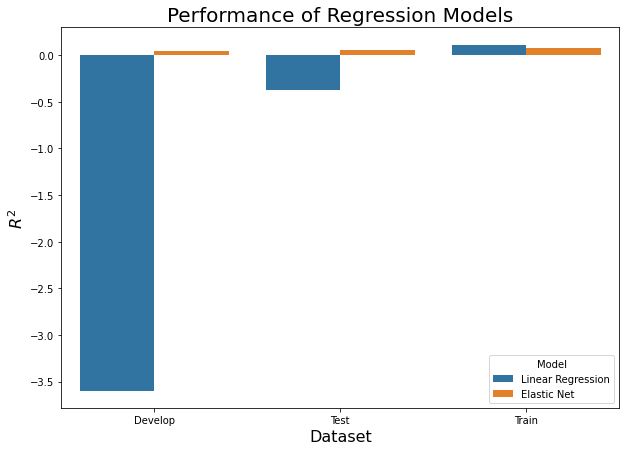

In [ ]:
plt.subplots(figsize=(10, 7))
sn.barplot(data=all_reg_agg, x="Dataset", y="score", hue="Model")
plt.xticks(range(3), ["Develop", "Test", "Train"])
plt.title("Performance of Regression Models", fontsize=20)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel(r"$R^2$", fontsize=16)
plt.show()

For the classifiers, the random forest performed much better than we would have expected. The neural network should in theory be able to model much more complex relationships in the data, however as we used over 700 features, perhaps the comparatively simpler random forest was able to overcome the noise and fit to the important information better.  

In [ ]:
# Load
rf_cls_results = pd.read_csv("dev/data/ncv_results/RandomForestClassifier.csv")
nn_cls_results = pd.read_csv("dev/data/ncv_results/MLPClassifier.csv")

# Aggregate
rf_cls_agg, rf_cls_best = aggregate_results(rf_cls_results, set(rf_cls_results.columns) - {"test_fold", "dev_fold", "train_score", "dev_score", "test_score"})
nn_cls_agg, nn_cls_best = aggregate_results(nn_cls_results, set(nn_cls_results.columns) - {"test_fold", "dev_fold", "train_score", "dev_score", "test_score"})

# Convert to format for plotting
all_cls_agg = pd.concat([rf_cls_agg, nn_cls_agg], axis=1).reset_index() \
.rename(columns={"index": "Dataset", 0: "Random Forest", 1: "Neural Network"}) \
.melt(id_vars=["Dataset"], var_name="Model", value_name="score")

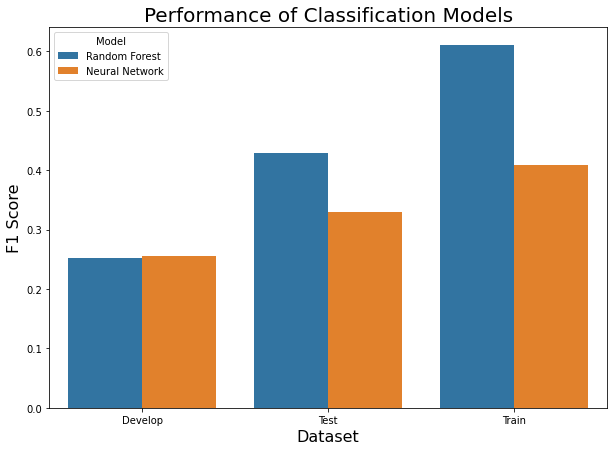

In [ ]:
plt.subplots(figsize=(10, 7))
sn.barplot(data=all_cls_agg, x="Dataset", y="score", hue="Model")
plt.xticks(range(3), ["Develop", "Test", "Train"])
plt.title("Performance of Classification Models", fontsize=20)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel(r"F1 Score", fontsize=16)
plt.show()

# Conclusion

Overall, the approach we took to this task did not turn out as well as we initially thought. The models we trained did not perform much better than the "dumb" guess of the modal value. I think that in order to classify sleep to any degree using this data, much more of the work needs to be focused on feature creation using domain knowledge such as the circadian rhythm modelling Walch et al. did in their paper.

# References
---

> [1] O. Walch, Y. Huang, D. Forger, and C. Goldstein, ‘Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device’, Sleep, vol. 42, no. 12, p. zsz180, Dec. 2019, doi: 10.1093/sleep/zsz180.

> [2]	B. H. W. te Lindert and E. J. W. Van Someren, ‘Sleep Estimates Using Microelectromechanical Systems (MEMS)’, Sleep, vol. 36, no. 5, pp. 781–789, May 2013, doi: 10.5665/sleep.2648.





